# GPU-IFIED CODE
### Can run with or without CUDA

In [22]:
import os
import json
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    balanced_accuracy_score,
    f1_score,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score
)
from lightgbm import LGBMClassifier
import lightgbm as lgb

In [23]:
import gc
import random
from IPython.display import clear_output

In [24]:
import json

In [25]:
import warnings
warnings.filterwarnings("ignore")

In [26]:
# Set the seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [27]:
# Settings
N_FOLDS = 10 #10
N_REPEATS = 3 #3
# BATCHSIZE = 128  # Not used 
CLASSES = 13
NUM_BOOST_ROUNDS = 1_500 # 1_500
EARLY_STOPPING_ROUNDS = 300
SAVE_MODEL_EVERY = 300
VERBOSE_EVAL = 5

# INPUT_SIZE = 83  # Not used

FIG_SIZE = (12, 12)
CHECKPOINT_DIR = "./checkpoints"

In [28]:
# Hyperparameters for LightGBM (from Optuna)

BEST_LGBM_PARAMS = {
    "bagging_fraction": 0.8705361427831009,
    "bagging_freq": 406,
    "boosting_type": "gbdt",
    "cat_l2": 0.026592839167437304,
    "cat_smooth": 0.0000016020190174477881,
    "colsample_bytree": 0.6749537326452014,
    "feature_fraction": 0.8837732391319297,
    "feature_fraction_bynode": 0.319478870787565,
    "learning_rate": 0.023269571043269426,
    "max_bin": 229,
    "max_depth": 97,
    "min_child_samples": 291,
    "min_child_weight": 3.532669502811908,
    "min_split_gain": 0.4728979135614666,
    "num_leaves": 143,
    "reg_alpha": 0.000008619857698099343,
    "reg_lambda": 0.015262204225165513,
    "objective": "multiclass",
    "metric": "None",
    "num_class": CLASSES,
    "verbosity": -1,
    "seed": SEED,
    'n_jobs': -1          # Utilize all available cores
}

In [29]:
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [30]:
# Create necessary folders
def create_folders():
    folders = [
        "outputs/overall",
        "outputs/validation_model",
        "outputs/evaluation_model_full_training_set",
    ]
    
    for folder in folders:
        os.makedirs(folder, exist_ok=True)

In [31]:
create_folders()

In [32]:
save_path = "outputs/overall/"

In [33]:
# Custom Macro F1 score metric for LightGBM
def macro_f1_score(preds, train_data):
    y_true = train_data.get_label()
    num_class = len(np.unique(y_true))  # Assuming CLASSES is defined globally
    
    # Validate the length of preds
    if len(preds) == len(y_true):  # If preds are class indices
        # LightGBM
        # print("len(preds) == len(y_true)")
        y_pred = preds
    elif len(preds) == len(y_true) * num_class:  # If preds are probabilities
        # print("len(preds) == len(y_true) * num_class")
        y_pred = np.argmax(preds.reshape(len(y_true), num_class), axis=1)
    else:
        raise ValueError("Unexpected prediction shape")
    # Reshape preds to (num_instances, num_class)
    y_pred = np.argmax(preds.reshape(-1, num_class), axis=1)

    # # Reshape preds to (num_instances, num_class)
    # y_pred = np.argmax(preds.reshape(-1, num_class), axis=1)
    
    # Calculate Macro F1 Score
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    
    return 'macro_f1', macro_f1, True  # The third parameter 'True' indicates higher is better

In [34]:
# Cell 2: Load and Preprocess Data

def load_and_preprocess_data(filepath):
    """
    Loads data from a CSV file, replaces placeholders, and separates features from target.
    
    Args:
        filepath (str): Path to the CSV file.
        
    Returns:
        data (pd.DataFrame): Feature dataframe.
        target (pd.Series): Target labels.
        feature_names (list): List of feature names.
    """
    data = pd.read_csv(filepath)
    
    # Replace '-' with 'None' in categorical columns
    data['service'] = data['service'].replace('-', 'None')
    data['proto'] = data['proto'].replace('-', 'None')
    
    # Separate features and target
    feature_names = data.drop(columns=['Attack_type']).columns.tolist()
    target = data['Attack_type']
    data = data.drop(columns=['Attack_type'])
    
    return data, target, feature_names

In [35]:
# Load the dataset
data, target, feature_names = load_and_preprocess_data('./RT_IOT2022_new.csv')

In [36]:
def encode_targets(target):
    """
    Encodes categorical target labels into numerical codes.
    
    Args:
        target (pd.Series): Categorical target labels.
        
    Returns:
        target_encoded (np.ndarray): Encoded target labels.
        class_labels (list): List of class names.
        target_encoder (LabelEncoder): Fitted LabelEncoder instance.
    """
    target_encoder = LabelEncoder()
    target_encoded = target_encoder.fit_transform(target)
    class_labels = target_encoder.classes_
    return target_encoded, class_labels, target_encoder

In [37]:
# Encode target labels
Y_encoded, class_labels, target_encoder = encode_targets(target)

In [38]:
print(f"Number of unique classes: {len(class_labels)}")
print(f"Class labels: {class_labels}")

Number of unique classes: 13
Class labels: ['ARP_poisioning' 'Alexa' 'DDOS_Slowloris' 'DOS_SYN_Hping' 'MQTT_Publish'
 'Metasploit_Brute_Force_SSH' 'NMAP_FIN_SCAN' 'NMAP_OS_DETECTION'
 'NMAP_TCP_scan' 'NMAP_UDP_SCAN' 'NMAP_XMAS_TREE_SCAN' 'Thing_Speak'
 'Wipro_bulb']


In [39]:
# Split the data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    data, Y_encoded, test_size=0.2, random_state=SEED, stratify=Y_encoded
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Clean up to save memory
del data
del target

Training set size: (167967, 83)
Test set size: (41992, 83)


In [40]:
# Cell 5: Define Preprocessing and Model Pipeline

# Identify numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=["int64", "float64", "float32"]).columns.tolist()
categorical_cols = ["proto", "service"]  # Adjust based on your data

# Update preprocessing for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])


# Define the preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Define LightGBM Classifier
lgbm_classifier = LGBMClassifier(**BEST_LGBM_PARAMS)

# Create the pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgbm_classifier)
])


In [41]:
# Sample a small subset for testing
X_sample = X_train.iloc[:100]
Y_sample = Y_train[:100]

# Perform stratified sampling to ensure all classes are represented
X_sample, _, Y_sample, _ = train_test_split(
    X_train, Y_train, test_size=0.9, random_state=SEED, stratify=Y_train
)

print(f"Sampled X_sample shape: {X_sample.shape}")
print(f"Sampled Y_sample shape: {Y_sample.shape}")
print(f"Unique classes in Y_sample: {np.unique(Y_sample)}")

# Fit the pipeline
model_pipeline.fit(X_sample, Y_sample)

# Predict using the pipeline
Y_pred_sample = model_pipeline.predict(X_sample)
Y_pred_proba_sample = model_pipeline.predict_proba(X_sample)

print("Sample Predictions:", Y_pred_sample)
print("Sample Probabilities:", Y_pred_proba_sample)

Sampled X_sample shape: (16796, 83)
Sampled Y_sample shape: (16796,)
Unique classes in Y_sample: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Sample Predictions: [ 4  3  1 ...  0  1 10]
Sample Probabilities: [[3.22985874e-03 1.19131197e-02 7.72752188e-04 ... 2.62649333e-04
  2.83921745e-03 1.50686034e-03]
 [1.45353621e-03 9.17051649e-03 2.33107443e-04 ... 2.45259684e-04
  1.90574257e-03 1.37584304e-04]
 [7.42331207e-04 9.90539581e-01 5.84235444e-05 ... 2.14484006e-04
  7.92287099e-04 3.42698704e-04]
 ...
 [5.32438149e-01 3.52311850e-01 5.24705039e-04 ... 1.07479711e-03
  4.99507014e-02 1.32750112e-02]
 [1.25437868e-03 9.88417919e-01 1.48361892e-04 ... 2.44611488e-04
  9.77753261e-04 6.27199257e-04]
 [2.36019517e-03 1.75445132e-02 2.25345436e-04 ... 9.21243850e-01
  2.13732887e-03 3.98850623e-04]]


In [42]:
from sklearn.metrics import make_scorer

### NEW K-Fold (Correct)
the best here is saved (best_lgbm_model.lgb), every fold is saved in 

In [43]:
# # Cross-Validation
# # Initialize cross-validation
# rskf = RepeatedStratifiedKFold(n_splits=N_FOLDS, n_repeats=N_REPEATS, random_state=SEED)

# # Variables to track the best model
# best_macro_f1 = -float('inf')
# best_model_path = os.path.join(CHECKPOINT_DIR, "best_lgbm_model.lgb")

# for fold, (train_idx, val_idx) in enumerate(rskf.split(X_train, Y_train), 1):
#     print(f"\nFold {fold}/{N_FOLDS * N_REPEATS}")
    
#     # Split the data
#     X_train_fold = X_train.iloc[train_idx].copy()
#     Y_train_fold = Y_train[train_idx].copy()
#     X_valid_fold = X_train.iloc[val_idx].copy()
#     Y_valid_fold = Y_train[val_idx].copy()
    
#     print(f"Before preprocessing: X_train_fold shape: {X_train_fold.shape}, X_valid_fold shape: {X_valid_fold.shape}")

#     # Preprocessing
#     preprocessor.fit(X_train_fold)
#     X_train_transformed = preprocessor.transform(X_train_fold)
#     X_valid_transformed = preprocessor.transform(X_valid_fold)
    
#     print(f"After preprocessing: X_train_fold shape: {X_train_transformed.shape}, X_valid_fold shape: {X_valid_transformed.shape}")

#     # LightGBM Dataset
#     dtrain = lgb.Dataset(X_train_transformed, label=Y_train_fold)
#     dvalid = lgb.Dataset(X_valid_transformed, label=Y_valid_fold, reference=dtrain)

#     # Initialize model for incremental training
#     init_model = None
#     checkpoint_path = os.path.join(CHECKPOINT_DIR, f"lgb_fold_{fold}.lgb")
#     if os.path.exists(checkpoint_path):
#         print(f"Resuming training for fold {fold} from {checkpoint_path}")
#         init_model = lgb.Booster(model_file=checkpoint_path)

#     # Train LightGBM with proper num_boost_round and callbacks
#     model = lgb.train(
#         params=BEST_LGBM_PARAMS,
#         train_set=dtrain,
#         valid_sets=[dtrain, dvalid],
#         valid_names=['train', 'validation'],
#         feval=macro_f1_score,
#         num_boost_round=NUM_BOOST_ROUNDS,
#         init_model=init_model,  # Incremental training
#         callbacks=[
#             lgb.log_evaluation(VERBOSE_EVAL),
#             lgb.early_stopping(EARLY_STOPPING_ROUNDS)
#         ]
#     )

#     # Save the model checkpoint
#     model.save_model(checkpoint_path)
#     print(f"Fold {fold} model checkpoint saved to {checkpoint_path}")

#     # Predict on Training and Validation Sets
#     Y_train_pred_proba = model.predict(X_train_transformed)
#     Y_train_pred = np.argmax(Y_train_pred_proba.reshape(len(Y_train_fold), -1), axis=1)

#     Y_valid_pred_proba = model.predict(X_valid_transformed)
#     Y_valid_pred = np.argmax(Y_valid_pred_proba.reshape(len(Y_valid_fold), -1), axis=1)

#     # Compute Training Metrics
#     train_bal_acc = balanced_accuracy_score(Y_train_fold, Y_train_pred)
#     train_accuracy = accuracy_score(Y_train_fold, Y_train_pred)
#     train_macro_f1 = f1_score(Y_train_fold, Y_train_pred, average='macro')
#     train_precision = precision_score(Y_train_fold, Y_train_pred, average='macro', zero_division=0)
#     train_recall = recall_score(Y_train_fold, Y_train_pred, average='macro', zero_division=0)
#     train_auc = roc_auc_score(
#         label_binarize(Y_train_fold, classes=np.arange(CLASSES)),
#         Y_train_pred_proba,
#         average='macro',
#         multi_class='ovo'
#     )

#     # Compute Validation Metrics
#     val_bal_acc = balanced_accuracy_score(Y_valid_fold, Y_valid_pred)
#     val_accuracy = accuracy_score(Y_valid_fold, Y_valid_pred)
#     val_macro_f1 = f1_score(Y_valid_fold, Y_valid_pred, average='macro')
#     val_precision = precision_score(Y_valid_fold, Y_valid_pred, average='macro', zero_division=0)
#     val_recall = recall_score(Y_valid_fold, Y_valid_pred, average='macro', zero_division=0)
#     val_auc = roc_auc_score(
#         label_binarize(Y_valid_fold, classes=np.arange(CLASSES)),
#         Y_valid_pred_proba,
#         average='macro',
#         multi_class='ovo'
#     )

#     # Print Metrics
#     print(f"Training Balanced Accuracy: {train_bal_acc:.4f}")
#     print(f"Validation Balanced Accuracy: {val_bal_acc:.4f}")
#     print(f"Training Accuracy: {train_accuracy:.4f}")
#     print(f"Validation Accuracy: {val_accuracy:.4f}")
#     print(f"Training Macro F1 Score: {train_macro_f1:.4f}")
#     print(f"Validation Macro F1 Score: {val_macro_f1:.4f}")
#     print(f"Training Precision (Macro): {train_precision:.4f}")
#     print(f"Validation Precision (Macro): {val_precision:.4f}")
#     print(f"Training Recall (Macro): {train_recall:.4f}")
#     print(f"Validation Recall (Macro): {val_recall:.4f}")
#     print(f"Training ROC AUC Score: {train_auc:.4f}")
#     print(f"Validation ROC AUC Score: {val_auc:.4f}")
    
#     # Save metrics for this fold, including predictions
#     metrics = {
#         "train_balanced_accuracy": train_bal_acc,
#         "train_accuracy": train_accuracy,
#         "train_macro_f1": train_macro_f1,
#         "train_precision_macro": train_precision,
#         "train_recall_macro": train_recall,
#         "train_auc": train_auc,
#         "validation_balanced_accuracy": val_bal_acc,
#         "validation_accuracy": val_accuracy,
#         "validation_macro_f1": val_macro_f1,
#         "validation_precision_macro": val_precision,
#         "validation_recall_macro": val_recall,
#         "validation_auc": val_auc,
#         "val_y_true": Y_valid_fold.tolist(),
#         "val_y_pred": Y_valid_pred.tolist(),
#         "val_y_score": Y_valid_pred_proba.tolist()
#     }
#     metrics_file = os.path.join(CHECKPOINT_DIR, f"metrics_fold{fold}.json")
#     with open(metrics_file, 'w') as f:
#         json.dump(metrics, f, indent=4)
#     print(f"Metrics saved to {metrics_file}")
    

#     # Save Best Model
#     if val_macro_f1 > best_macro_f1:
#         best_macro_f1 = val_macro_f1
#         model.save_model(best_model_path)
#         print(f"Best model updated and saved to {best_model_path} with Macro F1: {best_macro_f1:.4f}")

#     # Clean Up
#     del X_train_fold, Y_train_fold, X_valid_fold, Y_valid_fold, Y_train_pred, Y_train_pred_proba, Y_valid_pred, Y_valid_pred_proba
#     gc.collect()

# print("Cross-validation completed successfully.")



Fold 1/30
Before preprocessing: X_train_fold shape: (151170, 83), X_valid_fold shape: (16797, 83)
After preprocessing: X_train_fold shape: (151170, 94), X_valid_fold shape: (16797, 94)
Training until validation scores don't improve for 300 rounds
[5]	train's macro_f1: 0.143353	validation's macro_f1: 0.143406
[10]	train's macro_f1: 0.234888	validation's macro_f1: 0.232895
[15]	train's macro_f1: 0.734291	validation's macro_f1: 0.732613
[20]	train's macro_f1: 0.744563	validation's macro_f1: 0.744064
[25]	train's macro_f1: 0.768711	validation's macro_f1: 0.7553
[30]	train's macro_f1: 0.791869	validation's macro_f1: 0.779889
[35]	train's macro_f1: 0.805392	validation's macro_f1: 0.789169


KeyboardInterrupt: 

In [ ]:
# import os
# import json
# import gc
# import numpy as np
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.metrics import (
#     f1_score,
#     balanced_accuracy_score,
#     roc_auc_score,
#     accuracy_score,
#     precision_score,
#     recall_score
# )
# from sklearn.preprocessing import label_binarize
# import lightgbm as lgb

# # Assume these are already defined:
# # X_train, Y_train, CHECKPOINT_DIR, N_FOLDS, N_REPEATS, SEED, BEST_LGBM_PARAMS,
# # NUM_BOOST_ROUNDS, EARLY_STOPPING_ROUNDS, VERBOSE_EVAL, macro_f1_score, CLSSES, class_labels
# #
# # Also assume your preprocessor is defined as in Cell 5:
# #
# # from sklearn.pipeline import Pipeline
# # from sklearn.compose import ColumnTransformer
# # from sklearn.preprocessing import StandardScaler, OneHotEncoder
# #
# # numerical_cols = X_train.select_dtypes(include=["int64", "float64", "float32"]).columns.tolist()
# # categorical_cols = ["proto", "service"]
# #
# # numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])
# # categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
# #
# # preprocessor = ColumnTransformer(
# #     transformers=[
# #         ('num', numerical_transformer, numerical_cols),
# #         ('cat', categorical_transformer, categorical_cols)
# #     ]
# # )

# # Variables to track the best model (using LightGBM's save_model method)
# best_macro_f1 = -float('inf')
# best_model_path = os.path.join(CHECKPOINT_DIR, "best_lgbm_model.lgbm")

# # Initialize cross-validation
# rskf = RepeatedStratifiedKFold(n_splits=N_FOLDS, n_repeats=N_REPEATS, random_state=SEED)

# for fold, (train_idx, val_idx) in enumerate(rskf.split(X_train, Y_train), 1):
#     print(f"\nFold {fold}/{N_FOLDS * N_REPEATS}")
    
#     # Split the data
#     X_train_fold = X_train.iloc[train_idx].copy()
#     Y_train_fold = Y_train[train_idx].copy()
#     X_valid_fold = X_train.iloc[val_idx].copy()
#     Y_valid_fold = Y_train[val_idx].copy()
    
#     print(f"Before preprocessing: X_train_fold shape: {X_train_fold.shape}, X_valid_fold shape: {X_valid_fold.shape}")
    
#     # --- Preprocessing ---
#     # Fit the preprocessor on the training fold and transform both sets
#     preprocessor.fit(X_train_fold)
#     X_train_transformed = preprocessor.transform(X_train_fold)
#     X_valid_transformed = preprocessor.transform(X_valid_fold)
    
#     print(f"After preprocessing: X_train_fold shape: {X_train_transformed.shape}, X_valid_fold shape: {X_valid_transformed.shape}")
    
#     # --- Create LightGBM Datasets ---
#     dtrain = lgb.Dataset(X_train_transformed, label=Y_train_fold)
#     dvalid = lgb.Dataset(X_valid_transformed, label=Y_valid_fold, reference=dtrain)
    
#     # Initialize model for incremental training
#     init_model = None
#     checkpoint_path = os.path.join(CHECKPOINT_DIR, f"lgb_fold_{fold}.lgb")
#     if os.path.exists(checkpoint_path):
#         print(f"Resuming training for fold {fold} from {checkpoint_path}")
#         init_model = lgb.Booster(model_file=checkpoint_path)
    
#     # --- Train LightGBM ---
#     model = lgb.train(
#         params=BEST_LGBM_PARAMS,
#         train_set=dtrain,
#         valid_sets=[dtrain, dvalid],
#         valid_names=['train', 'validation'],
#         feval=macro_f1_score,
#         num_boost_round=NUM_BOOST_ROUNDS,
#         init_model=init_model,  # Incremental training
#         callbacks=[
#             lgb.log_evaluation(VERBOSE_EVAL),
#             lgb.early_stopping(EARLY_STOPPING_ROUNDS)
#         ]
#     )
    
#     # Save the model checkpoint for this fold (as a .lgbm file)
#     checkpoint_path = os.path.join(CHECKPOINT_DIR, f"lgb_fold_{fold}.lgbm")
#     model.save_model(checkpoint_path)
#     print(f"Fold {fold} model checkpoint saved to {checkpoint_path}")
    
#     # --- Predictions ---
#     # For predictions, LightGBM's model outputs probabilities.
#     Y_train_pred_proba = model.predict(X_train_transformed)
#     Y_train_pred = np.argmax(Y_train_pred_proba.reshape(len(Y_train_fold), -1), axis=1)
    
#     Y_valid_pred_proba = model.predict(X_valid_transformed)
#     Y_valid_pred = np.argmax(Y_valid_pred_proba.reshape(len(Y_valid_fold), -1), axis=1)
    
#     # --- Compute Metrics ---
#     # Training metrics
#     train_bal_acc = balanced_accuracy_score(Y_train_fold, Y_train_pred)
#     train_accuracy = accuracy_score(Y_train_fold, Y_train_pred)
#     train_macro_f1 = f1_score(Y_train_fold, Y_train_pred, average='macro')
#     train_precision = precision_score(Y_train_fold, Y_train_pred, average='macro', zero_division=0)
#     train_recall = recall_score(Y_train_fold, Y_train_pred, average='macro', zero_division=0)
#     train_auc = roc_auc_score(
#         label_binarize(Y_train_fold, classes=np.arange(CLASSES)),
#         Y_train_pred_proba,
#         average='macro',
#         multi_class='ovo'
#     )
    
#     # Validation metrics
#     val_bal_acc = balanced_accuracy_score(Y_valid_fold, Y_valid_pred)
#     val_accuracy = accuracy_score(Y_valid_fold, Y_valid_pred)
#     val_macro_f1 = f1_score(Y_valid_fold, Y_valid_pred, average='macro')
#     val_precision = precision_score(Y_valid_fold, Y_valid_pred, average='macro', zero_division=0)
#     val_recall = recall_score(Y_valid_fold, Y_valid_pred, average='macro', zero_division=0)
#     val_auc = roc_auc_score(
#         label_binarize(Y_valid_fold, classes=np.arange(CLASSES)),
#         Y_valid_pred_proba,
#         average='macro',
#         multi_class='ovo'
#     )
    
#     # Print Metrics
#     print(f"Training Balanced Accuracy: {train_bal_acc:.4f}")
#     print(f"Validation Balanced Accuracy: {val_bal_acc:.4f}")
#     print(f"Training Accuracy: {train_accuracy:.4f}")
#     print(f"Validation Accuracy: {val_accuracy:.4f}")
#     print(f"Training Macro F1 Score: {train_macro_f1:.4f}")
#     print(f"Validation Macro F1 Score: {val_macro_f1:.4f}")
#     print(f"Training Precision (Macro): {train_precision:.4f}")
#     print(f"Validation Precision (Macro): {val_precision:.4f}")
#     print(f"Training Recall (Macro): {train_recall:.4f}")
#     print(f"Validation Recall (Macro): {val_recall:.4f}")
#     print(f"Training ROC AUC Score: {train_auc:.4f}")
#     print(f"Validation ROC AUC Score: {val_auc:.4f}")
    
#     # Save metrics for this fold, including predictions
#     metrics = {
#         "train_balanced_accuracy": train_bal_acc,
#         "train_accuracy": train_accuracy,
#         "train_macro_f1": train_macro_f1,
#         "train_precision_macro": train_precision,
#         "train_recall_macro": train_recall,
#         "train_auc": train_auc,
#         "validation_balanced_accuracy": val_bal_acc,
#         "validation_accuracy": val_accuracy,
#         "validation_macro_f1": val_macro_f1,
#         "validation_precision_macro": val_precision,
#         "validation_recall_macro": val_recall,
#         "validation_auc": val_auc,
#         "val_y_true": Y_valid_fold.tolist(),
#         "val_y_pred": Y_valid_pred.tolist(),
#         "val_y_score": Y_valid_pred_proba.tolist()
#     }
#     metrics_file = os.path.join(CHECKPOINT_DIR, f"metrics_fold{fold}.json")
#     with open(metrics_file, 'w') as f:
#         json.dump(metrics, f, indent=4)
#     print(f"Metrics saved to {metrics_file}")
    
#     # --- Save Best Model ---
#     # If the current fold yields a higher Macro F1 on validation, update the best model.
#     if val_macro_f1 > best_macro_f1:
#         best_macro_f1 = val_macro_f1
#         # Save the model using LightGBM's native save_model method.
#         model.save_model(best_model_path)
#         print(f"Best model updated and saved to {best_model_path} with Macro F1: {best_macro_f1:.4f}")
    
#     # Clean up
#     del X_train_fold, Y_train_fold, X_valid_fold, Y_valid_fold
#     gc.collect()

# print("Cross-validation completed successfully.")



Fold 1/30
Before preprocessing: X_train_fold shape: (151170, 83), X_valid_fold shape: (16797, 83)
After preprocessing: X_train_fold shape: (151170, 94), X_valid_fold shape: (16797, 94)
Resuming training for fold 1 from ./checkpoints/lgb_fold_1.lgb
Training until validation scores don't improve for 300 rounds
[15]	train's macro_f1: 0.719998	validation's macro_f1: 0.724695
[20]	train's macro_f1: 0.745256	validation's macro_f1: 0.744416
[25]	train's macro_f1: 0.772479	validation's macro_f1: 0.747823
[30]	train's macro_f1: 0.796959	validation's macro_f1: 0.787513
[35]	train's macro_f1: 0.807062	validation's macro_f1: 0.793865
[40]	train's macro_f1: 0.812625	validation's macro_f1: 0.797629
[45]	train's macro_f1: 0.820924	validation's macro_f1: 0.810817
[50]	train's macro_f1: 0.822861	validation's macro_f1: 0.812861
[55]	train's macro_f1: 0.826795	validation's macro_f1: 0.818583
[60]	train's macro_f1: 0.828593	validation's macro_f1: 0.824635
[65]	train's macro_f1: 0.830539	validation's macr

------

In [ ]:
import os
import json
import gc
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import (
    f1_score,
    balanced_accuracy_score,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score
)
from sklearn.preprocessing import label_binarize
import lightgbm as lgb

# Variables to track the best model (saved as a tuple: (preprocessor, booster))
best_macro_f1 = -float('inf')
best_model_path = os.path.join(CHECKPOINT_DIR, "best_lgbm_model.lgbm")

# Initialize cross-validation
rskf = RepeatedStratifiedKFold(n_splits=N_FOLDS, n_repeats=N_REPEATS, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(rskf.split(X_train, Y_train), 1):
    print(f"\nFold {fold}/{N_FOLDS * N_REPEATS}")
    
    # Split the data
    X_train_fold = X_train.iloc[train_idx].copy()
    Y_train_fold = Y_train[train_idx].copy()
    X_valid_fold = X_train.iloc[val_idx].copy()
    Y_valid_fold = Y_train[val_idx].copy()
    
    print(f"Before preprocessing: X_train_fold shape: {X_train_fold.shape}, "
          f"X_valid_fold shape: {X_valid_fold.shape}")
    
    # --- Preprocessing ---
    # Fit the preprocessor on the training fold and transform both sets
    preprocessor.fit(X_train_fold)
    X_train_transformed = preprocessor.transform(X_train_fold)
    X_valid_transformed = preprocessor.transform(X_valid_fold)
    
    print(f"After preprocessing: X_train_fold shape: {X_train_transformed.shape}, "
          f"X_valid_fold shape: {X_valid_transformed.shape}")
    
    # --- Create LightGBM Datasets ---
    dtrain = lgb.Dataset(X_train_transformed, label=Y_train_fold)
    dvalid = lgb.Dataset(X_valid_transformed, label=Y_valid_fold, reference=dtrain)
    
    # Initialize model for incremental training
    init_model = None
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f"lgb_fold_{fold}.lgbm")
    if os.path.exists(checkpoint_path):
        print(f"Resuming training for fold {fold} from {checkpoint_path}")
        init_model = lgb.Booster(model_file=checkpoint_path)
    
    # --- Train LightGBM ---
    booster = lgb.train(
        params=BEST_LGBM_PARAMS,
        train_set=dtrain,
        valid_sets=[dtrain, dvalid],
        valid_names=['train', 'validation'],
        feval=macro_f1_score,
        num_boost_round=NUM_BOOST_ROUNDS,
        init_model=init_model,
        callbacks=[
            lgb.log_evaluation(VERBOSE_EVAL),
            lgb.early_stopping(EARLY_STOPPING_ROUNDS)
        ]
    )
    
    # # Optional: Save the booster checkpoint (if you wish to use LGBM's native save_model)
    # checkpoint_path = os.path.join(CHECKPOINT_DIR, f"lgb_fold_{fold}.lgbm")
    # booster.save_model(checkpoint_path)
    # print(f"Fold {fold} booster checkpoint saved to {checkpoint_path}")
    
    # --- Predictions ---
    # For predictions, the booster outputs probabilities.
    Y_train_pred_proba = booster.predict(X_train_transformed)
    Y_train_pred = np.argmax(Y_train_pred_proba.reshape(len(Y_train_fold), -1), axis=1)
    
    Y_valid_pred_proba = booster.predict(X_valid_transformed)
    Y_valid_pred = np.argmax(Y_valid_pred_proba.reshape(len(Y_valid_fold), -1), axis=1)
    
    # --- Compute Metrics ---
    # Training metrics
    train_bal_acc = balanced_accuracy_score(Y_train_fold, Y_train_pred)
    train_accuracy = accuracy_score(Y_train_fold, Y_train_pred)
    train_macro_f1 = f1_score(Y_train_fold, Y_train_pred, average='macro')
    train_precision = precision_score(Y_train_fold, Y_train_pred, average='macro', zero_division=0)
    train_recall = recall_score(Y_train_fold, Y_train_pred, average='macro', zero_division=0)
    train_auc = roc_auc_score(
        label_binarize(Y_train_fold, classes=np.arange(CLASSES)),
        Y_train_pred_proba,
        average='macro',
        multi_class='ovo'
    )
    
    # Validation metrics
    val_bal_acc = balanced_accuracy_score(Y_valid_fold, Y_valid_pred)
    val_accuracy = accuracy_score(Y_valid_fold, Y_valid_pred)
    val_macro_f1 = f1_score(Y_valid_fold, Y_valid_pred, average='macro')
    val_precision = precision_score(Y_valid_fold, Y_valid_pred, average='macro', zero_division=0)
    val_recall = recall_score(Y_valid_fold, Y_valid_pred, average='macro', zero_division=0)
    val_auc = roc_auc_score(
        label_binarize(Y_valid_fold, classes=np.arange(CLASSES)),
        Y_valid_pred_proba,
        average='macro',
        multi_class='ovo'
    )
    
    # Print Metrics
    print(f"Training Balanced Accuracy: {train_bal_acc:.4f}")
    print(f"Validation Balanced Accuracy: {val_bal_acc:.4f}")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Training Macro F1 Score: {train_macro_f1:.4f}")
    print(f"Validation Macro F1 Score: {val_macro_f1:.4f}")
    print(f"Training Precision (Macro): {train_precision:.4f}")
    print(f"Validation Precision (Macro): {val_precision:.4f}")
    print(f"Training Recall (Macro): {train_recall:.4f}")
    print(f"Validation Recall (Macro): {val_recall:.4f}")
    print(f"Training ROC AUC Score: {train_auc:.4f}")
    print(f"Validation ROC AUC Score: {val_auc:.4f}")
    
    # Save metrics for this fold, including predictions
    metrics = {
        "train_balanced_accuracy": train_bal_acc,
        "train_accuracy": train_accuracy,
        "train_macro_f1": train_macro_f1,
        "train_precision_macro": train_precision,
        "train_recall_macro": train_recall,
        "train_auc": train_auc,
        "validation_balanced_accuracy": val_bal_acc,
        "validation_accuracy": val_accuracy,
        "validation_macro_f1": val_macro_f1,
        "validation_precision_macro": val_precision,
        "validation_recall_macro": val_recall,
        "validation_auc": val_auc,
        "val_y_true": Y_valid_fold.tolist(),
        "val_y_pred": Y_valid_pred.tolist(),
        "val_y_score": Y_valid_pred_proba.tolist()
    }
    metrics_file = os.path.join(CHECKPOINT_DIR, f"metrics_fold{fold}.json")
    with open(metrics_file, 'w') as f:
        json.dump(metrics, f, indent=4)
    print(f"Metrics saved to {metrics_file}")
    
    # --- Save Best Model ---
    # If the current fold yields a higher Macro F1 on validation, update the best model.
    if val_macro_f1 > best_macro_f1:
        best_macro_f1 = val_macro_f1
        # Wrap the fold's preprocessor and booster into a tuple and save with joblib
        best_model = (preprocessor, booster)
        joblib.dump(best_model, best_model_path)
        print(f"Best model updated and saved to {best_model_path} with Macro F1: {best_macro_f1:.4f}")
    
    # Optional: Save the model for each fold (as a tuple: (preprocessor, booster)) with joblib
    fold_model_path = os.path.join(CHECKPOINT_DIR, f"model_fold{fold}.lgbm")
    fold_model = (preprocessor, booster)
    joblib.dump(fold_model, fold_model_path)
    print(f"Model for fold {fold} saved to {fold_model_path}")
    
    # Clean up
    del X_train_fold, Y_train_fold, X_valid_fold, Y_valid_fold 
    gc.collect()

print("Cross-validation completed successfully.")



Fold 1/30
Before preprocessing: X_train_fold shape: (151170, 83), X_valid_fold shape: (16797, 83)
After preprocessing: X_train_fold shape: (151170, 94), X_valid_fold shape: (16797, 94)
Resuming training for fold 1 from ./checkpoints/lgb_fold_1.lgbm
Training until validation scores don't improve for 300 rounds
[480]	train's macro_f1: 0.983126	validation's macro_f1: 0.979215
[485]	train's macro_f1: 0.983146	validation's macro_f1: 0.979215
Did not meet early stopping. Best iteration is:
[478]	train's macro_f1: 0.983126	validation's macro_f1: 0.979215
Fold 1 booster checkpoint saved to ./checkpoints/lgb_fold_1.lgbm
Training Balanced Accuracy: 0.9702
Validation Balanced Accuracy: 0.9653
Training Accuracy: 0.9994
Validation Accuracy: 0.9990
Training Macro F1 Score: 0.9831
Validation Macro F1 Score: 0.9792
Training Precision (Macro): 0.9984
Validation Precision (Macro): 0.9984
Training Recall (Macro): 0.9702
Validation Recall (Macro): 0.9653
Training ROC AUC Score: 1.0000
Validation ROC AUC 

-----

In [62]:
# Function to load all fold metrics
def load_all_fold_metrics(n_folds, metrics_per_fold_path):
    all_train_metrics = []
    all_val_metrics = []
    all_y_true = []
    all_y_pred = []
    all_y_score = []

    for fold in range(n_folds):
        metrics_file = os.path.join(metrics_per_fold_path, f"metrics_fold{fold + 1}.json")
        if os.path.exists(metrics_file):
            with open(metrics_file, 'r') as f:
                metrics = json.load(f)

                # Extract the metrics
                train_metrics = {
                    'balanced_accuracy': metrics.get('train_balanced_accuracy', None),
                    'accuracy': metrics.get('train_accuracy', None),
                    'macro_f1': metrics.get('train_macro_f1', None),
                    'precision_macro': metrics.get('train_precision_macro', None),
                    'recall_macro': metrics.get('train_recall_macro', None),
                    'auc': metrics.get('train_auc', None)
                }
                val_metrics = {
                    'balanced_accuracy': metrics.get('validation_balanced_accuracy', None),
                    'accuracy': metrics.get('validation_accuracy', None),
                    'macro_f1': metrics.get('validation_macro_f1', None),
                    'precision_macro': metrics.get('validation_precision_macro', None),
                    'recall_macro': metrics.get('validation_recall_macro', None),
                    'auc': metrics.get('validation_auc', None)
                }

                all_train_metrics.append(train_metrics)
                all_val_metrics.append(val_metrics)

                all_y_true.extend(metrics.get('val_y_true', []))
                all_y_pred.extend(metrics.get('val_y_pred', []))
                all_y_score.extend(metrics.get('val_y_score', []))
        else:
            print(f"Metrics file for fold {fold + 1} not found.")

    return all_train_metrics, all_val_metrics, all_y_true, all_y_pred, all_y_score


In [63]:
# Function to compute mean and std of a specific metric across folds
def mean_and_std(metrics_list, metric_name):
    fold_values = [fold.get(metric_name) for fold in metrics_list if fold.get(metric_name) is not None]
    mean_val = np.mean(fold_values) if fold_values else None
    std_val = np.std(fold_values) if fold_values else None
    return mean_val, std_val


In [64]:
def compute_and_print_average_metrics(n_folds, metrics_per_fold_path, class_labels):
    """
    Loads all fold metrics, computes average training and validation metrics,
    and prints them in a formatted manner.
    
    Args:
        n_folds (int): Total number of cross-validation folds.
        metrics_per_fold_path (str): Directory path where fold metrics are saved.
        class_labels (list): List of class names.
    """
    # Load all fold metrics
    all_train_metrics, all_val_metrics, all_y_true, all_y_pred, all_y_score = load_all_fold_metrics(n_folds, metrics_per_fold_path)

    # Define metrics to analyze
    metrics_to_analyze = ['balanced_accuracy', 'accuracy', 'macro_f1', 'precision_macro', 'recall_macro', 'auc']

    # Initialize a dictionary to store average metrics
    average_metrics = {}

    print("\n----- Average Cross-Validation Metrics -----\n")
    for metric in metrics_to_analyze:
        train_mean, train_std = mean_and_std(all_train_metrics, metric)
        val_mean, val_std = mean_and_std(all_val_metrics, metric)

        average_metrics[f"train_{metric}"] = (train_mean, train_std)
        average_metrics[f"validation_{metric}"] = (val_mean, val_std)

        # Print the metrics in the desired format
        if train_mean is not None and train_std is not None:
            if metric == 'precision_macro':
                display_metric = 'Precision (Macro)'
            elif metric == 'recall_macro':
                display_metric = 'Recall (Macro)'
            else:
                display_metric = metric.capitalize().replace('_', ' ')
            print(f"Training {display_metric}: {train_mean:.4f} ± {train_std:.4f}")
        if val_mean is not None and val_std is not None:
            if metric == 'precision_macro':
                display_metric = 'Precision (Macro)'
            elif metric == 'recall_macro':
                display_metric = 'Recall (Macro)'
            else:
                display_metric = metric.capitalize().replace('_', ' ')
            print(f"Validation {display_metric}: {val_mean:.4f} ± {val_std:.4f}")
    print("\n--------------------------------------------\n")

    # Generate and save the classification report across all folds
    if all_y_true and all_y_pred:
        final_classification_report = classification_report(all_y_true, all_y_pred, target_names=class_labels, output_dict=True)
        report_df = pd.DataFrame(final_classification_report).transpose()
        report_file = os.path.join(metrics_per_fold_path, "average_classification_report.csv")
        report_df.to_csv(report_file, index=True)
        print("Average Classification Report:")
        print(report_df)
        print(f"\nClassification report saved to {report_file}\n")

        # Generate and save the confusion matrix across all folds
        cm = confusion_matrix(all_y_true, all_y_pred)
        plt.figure(figsize=FIG_SIZE)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Average Cross-Validation Confusion Matrix')
        cm_file = os.path.join(metrics_per_fold_path, 'average_confusion_matrix.png')
        plt.savefig(cm_file)
        plt.show()
        plt.close()
        print(f"Average Confusion Matrix saved to {cm_file}\n")
    else:
        print("No predictions found across folds. Skipping classification report and confusion matrix.\n")

    # Clean up to save memory
    del all_train_metrics, all_val_metrics, all_y_true, all_y_pred, all_y_score
    gc.collect()

In [65]:
def plot_roc_curves(Y_true, Y_score, class_labels, fig_size=(12, 12), save_path='./checkpoints_rf'):
    """
    Plots ROC curves for each class along with micro and macro averages.

    Args:
        Y_true (array-like): True labels.
        Y_score (array-like): Predicted probabilities.
        class_labels (list): List of class names.
        fig_size (tuple): Size of the plot.
        save_path (str): Directory path to save the ROC curve plot.
    """
    n_classes = CLASSES
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Binarize the test labels
    Y_true_bin = label_binarize(Y_true, classes=np.arange(n_classes))

    # Check if the number of classes in predicted probabilities matches
    if Y_score.shape[1] != n_classes:
        print(f"Y_score has shape {Y_score.shape}, expected number of classes {n_classes}")
        return

    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_true_bin[:, i], Y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_true_bin.ravel(), Y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    # Aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Interpolate all ROC curves at these points and average
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=fig_size)
    colors = plt.cm.get_cmap('tab10').colors

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
                 lw=2, label=f'ROC curve of class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label=f'macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})',
             color='navy', linestyle=':', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Test Set ROC Curves')
    plt.legend(loc="lower right", fontsize='small')
    roc_curve_file = os.path.join(save_path, 'test_roc_curves.png')
    plt.savefig(roc_curve_file)
    plt.show()
    plt.close()
    print(f"ROC Curves generated and saved to '{roc_curve_file}'\n")


----- Average Cross-Validation Metrics -----

Training Balanced accuracy: 0.9649 ± 0.0043
Validation Balanced accuracy: 0.9553 ± 0.0281
Training Accuracy: 0.9992 ± 0.0001
Validation Accuracy: 0.9986 ± 0.0004
Training Macro f1: 0.9795 ± 0.0028
Validation Macro f1: 0.9680 ± 0.0216
Training Precision (Macro): 0.9980 ± 0.0011
Validation Precision (Macro): 0.9937 ± 0.0142
Training Recall (Macro): 0.9649 ± 0.0043
Validation Recall (Macro): 0.9553 ± 0.0281
Training Auc: 1.0000 ± 0.0001
Validation Auc: 0.9996 ± 0.0008

--------------------------------------------

Average Classification Report:
                            precision    recall  f1-score        support
ARP_poisioning               0.982239  0.990108  0.986158   18600.000000
Alexa                        0.999367  0.999655  0.999511  208422.000000
DDOS_Slowloris               0.996853  0.989071  0.992947    1281.000000
DOS_SYN_Hping                1.000000  1.000000  1.000000  227181.000000
MQTT_Publish                 0.999799  0

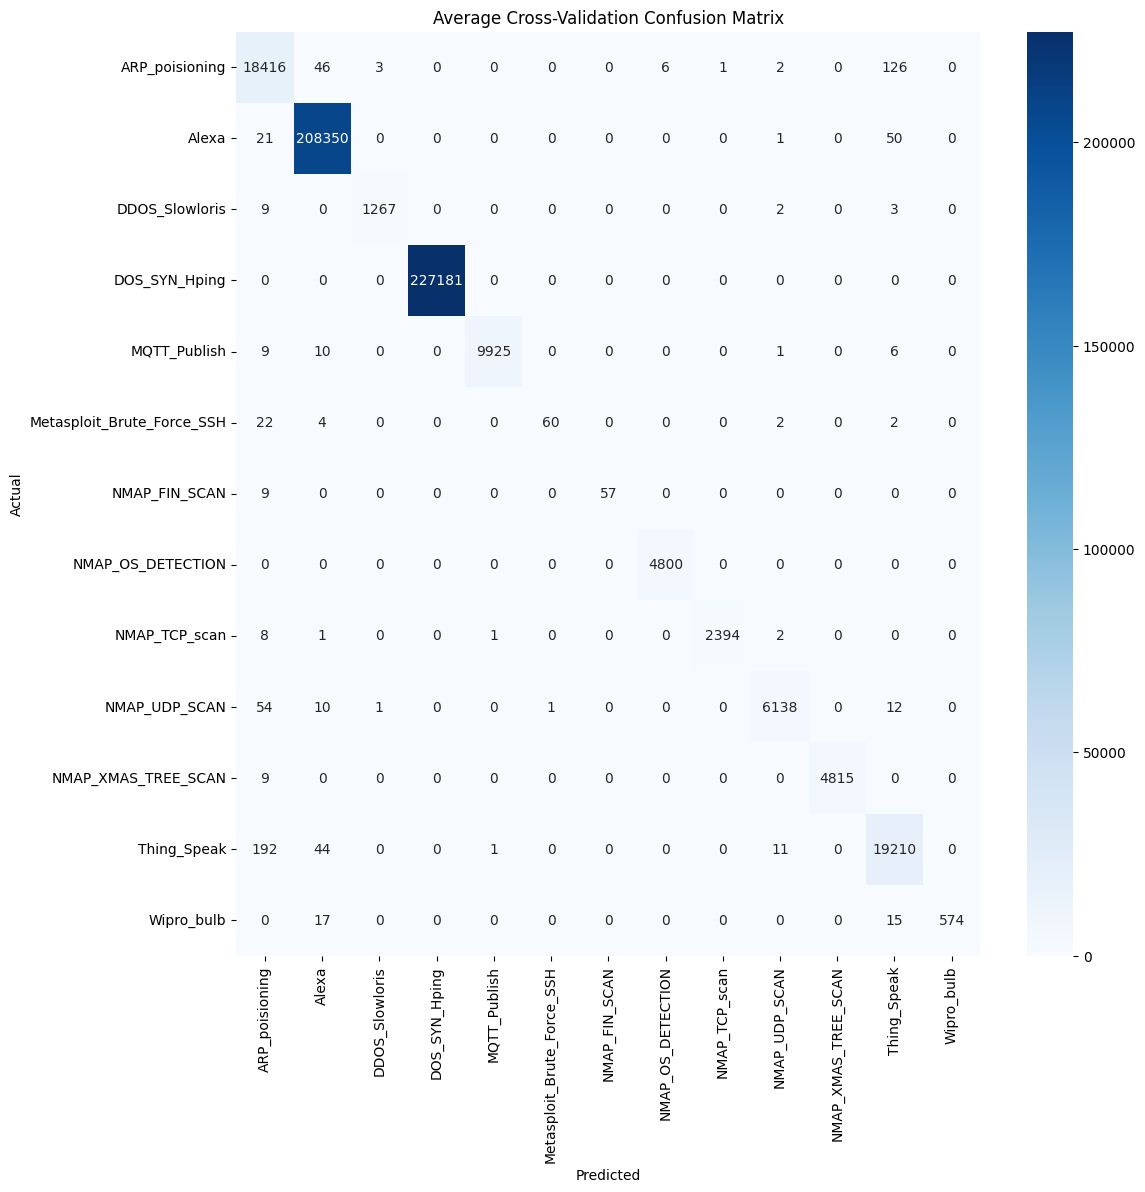

Average Confusion Matrix saved to ./checkpoints/average_confusion_matrix.png



In [66]:
# Call the function
total_folds = N_FOLDS * N_REPEATS

# Compute and print average cross-validation metrics
compute_and_print_average_metrics(
    n_folds=total_folds, 
    metrics_per_fold_path=CHECKPOINT_DIR, 
    class_labels=class_labels
)


Loading the best model from ./checkpoints/best_lgbm_model.lgb

Best model loaded from ./checkpoints/best_lgbm_model.lgb
Before preprocessing: X_test shape: (41992, 83)
After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating the best model on the test set...

Test Set Metrics:
Test Balanced Accuracy: 0.9685
Test Accuracy: 0.9975
Test Macro F1 Score: 0.9809
Test Precision (Macro): 0.9952
Test Recall (Macro): 0.9685
Test ROC AUC Score: 0.9997

Test metrics saved to ./checkpoints/test_metrics.json
Test classification report saved to ./checkpoints/test_classification_report.csv


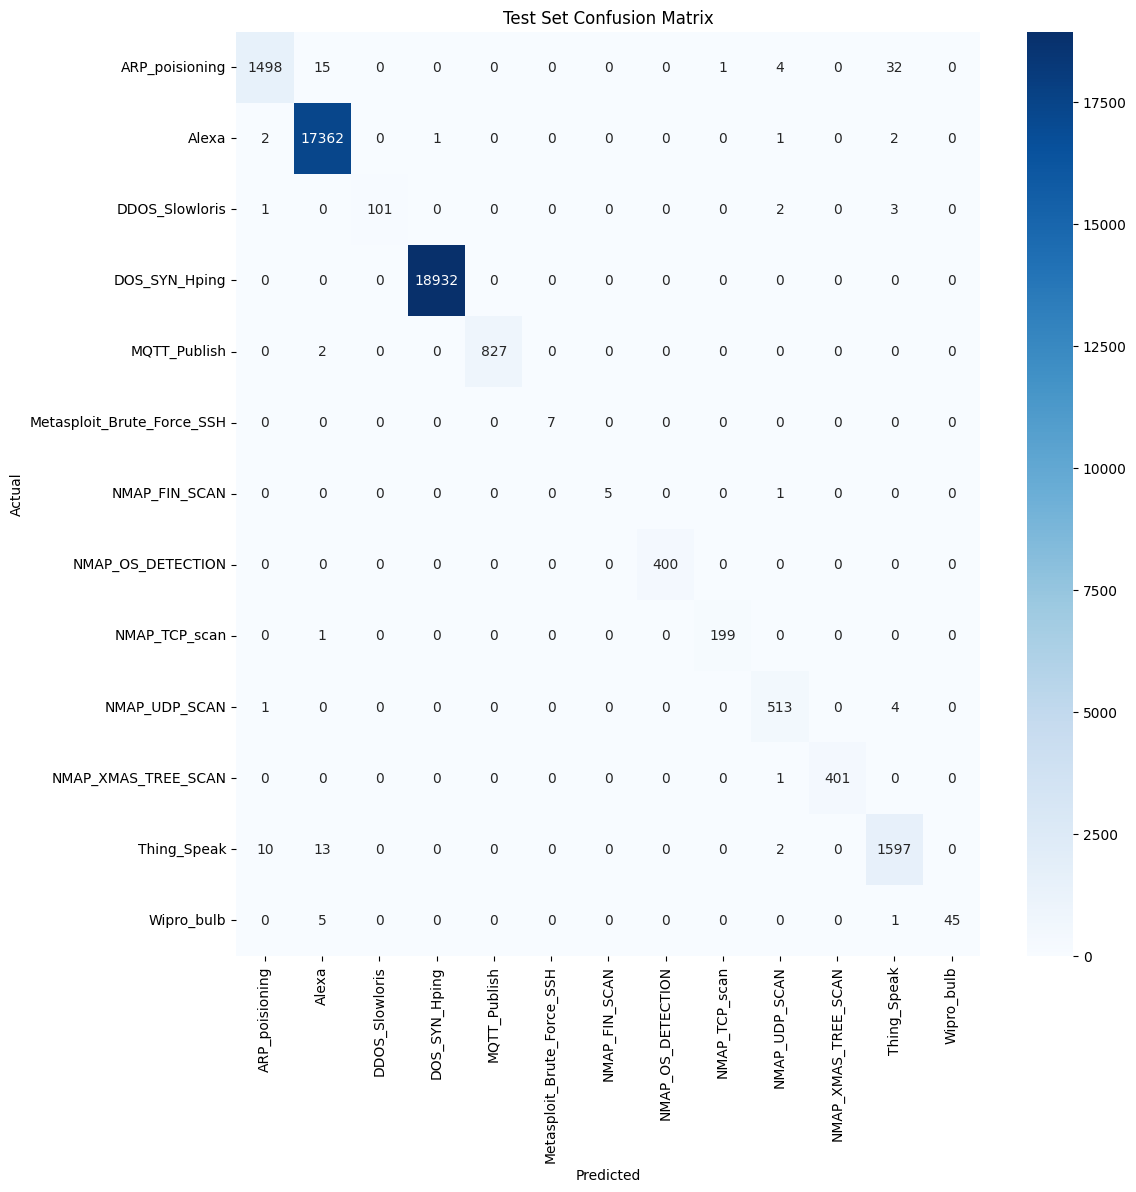

Confusion matrix saved to ./checkpoints/test_confusion_matrix.png


Generating ROC Curves...


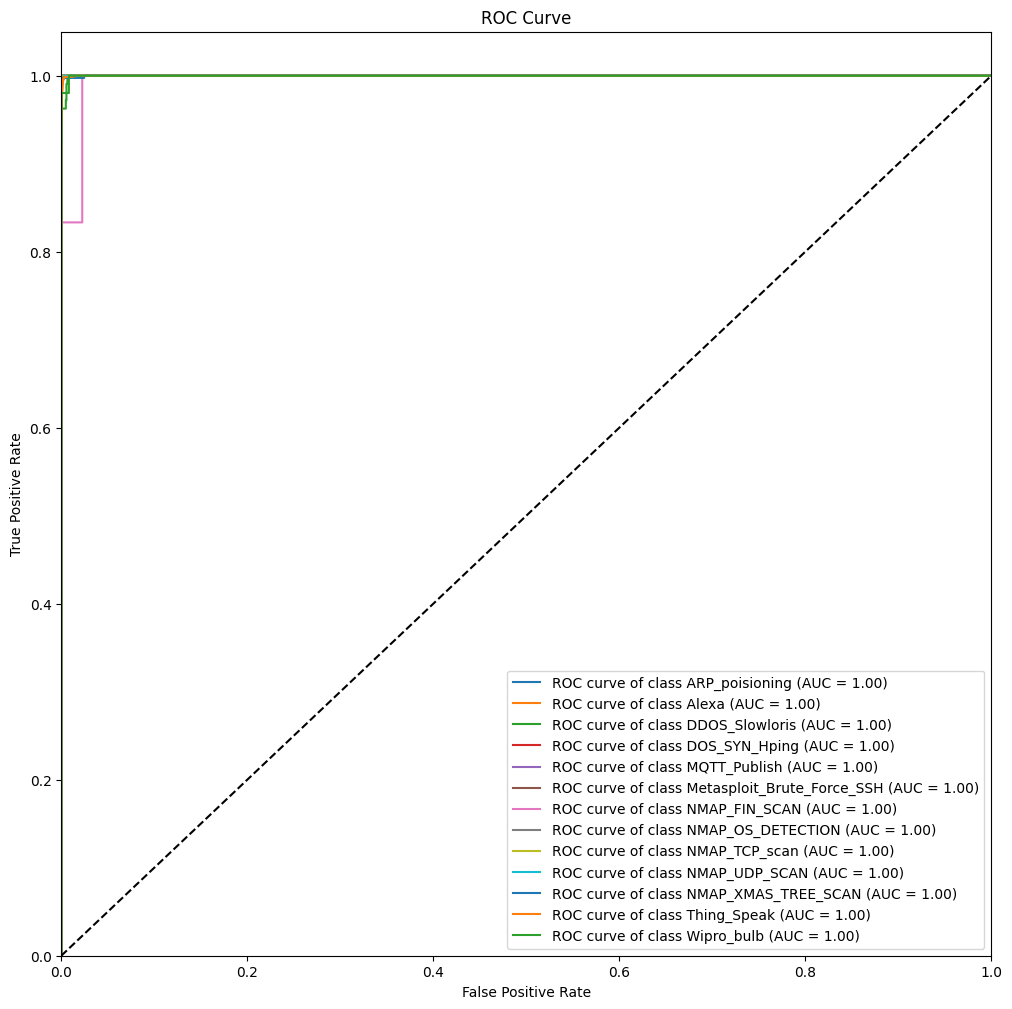

20152

In [55]:
# ---------------------------
# 3. Load the Best Model and Evaluate on the Test Set
# ---------------------------

# Path to the best model
best_model_path = os.path.join(CHECKPOINT_DIR, "best_lgbm_model.lgb")

# Check if the best model exists
if os.path.exists(best_model_path):
    print(f"\nLoading the best model from {best_model_path}")
    # Load the best model
    best_model = lgb.Booster(model_file=best_model_path)
    print(f"\nBest model loaded from {best_model_path}")
else:
    raise FileNotFoundError(f"No best model found at {best_model_path}. Ensure cross-validation was run successfully.")

# Preprocess the test set
preprocessor.fit(X_train)  # Ensure the preprocessor is fitted on the entire training set
X_test_transformed = preprocessor.transform(X_test)

# Print the shape before and after preprocessing
print(f"Before preprocessing: X_test shape: {X_test.shape}")
print(f"After preprocessing: X_test_transformed shape: {X_test_transformed.shape}")

# Evaluate on the test set
print("\nEvaluating the best model on the test set...")
Y_test_pred_proba = best_model.predict(X_test_transformed)
Y_test_pred = np.argmax(Y_test_pred_proba.reshape(len(Y_test), -1), axis=1)

# Compute Test Metrics
test_bal_acc = balanced_accuracy_score(Y_test, Y_test_pred)
test_accuracy = accuracy_score(Y_test, Y_test_pred)
test_macro_f1 = f1_score(Y_test, Y_test_pred, average='macro')
test_precision = precision_score(Y_test, Y_test_pred, average='macro', zero_division=0)
test_recall = recall_score(Y_test, Y_test_pred, average='macro', zero_division=0)
Y_test_bin = label_binarize(Y_test, classes=np.arange(CLASSES))
test_auc = roc_auc_score(Y_test_bin, Y_test_pred_proba, average='macro', multi_class='ovo')

# Print Test Metrics
print("\nTest Set Metrics:")
print(f"Test Balanced Accuracy: {test_bal_acc:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Macro F1 Score: {test_macro_f1:.4f}")
print(f"Test Precision (Macro): {test_precision:.4f}")
print(f"Test Recall (Macro): {test_recall:.4f}")
print(f"Test ROC AUC Score: {test_auc:.4f}")

# Save Test Metrics
test_metrics = {
    "test_balanced_accuracy": test_bal_acc,
    "test_accuracy": test_accuracy,
    "test_macro_f1": test_macro_f1,
    "test_precision_macro": test_precision,
    "test_recall_macro": test_recall,
    "test_auc": test_auc,
}
test_metrics_file = os.path.join(CHECKPOINT_DIR, "test_metrics.json")
with open(test_metrics_file, 'w') as f:
    json.dump(test_metrics, f, indent=4)
print(f"\nTest metrics saved to {test_metrics_file}")

# Classification Report
test_classification_report = classification_report(Y_test, Y_test_pred, target_names=class_labels, output_dict=True)
test_report_df = pd.DataFrame(test_classification_report).transpose()
test_report_file = os.path.join(CHECKPOINT_DIR, "test_classification_report.csv")
test_report_df.to_csv(test_report_file, index=True)
print(f"Test classification report saved to {test_report_file}")

# Confusion Matrix
cm_test = confusion_matrix(Y_test, Y_test_pred)
plt.figure(figsize=FIG_SIZE)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Set Confusion Matrix')
cm_file = os.path.join(CHECKPOINT_DIR, 'test_confusion_matrix.png')
plt.savefig(cm_file)
plt.show()
plt.close()
print(f"Confusion matrix saved to {cm_file}\n")

# ---------------------------
# 4. Generate ROC Curves
# ---------------------------

def plot_roc_curves(Y_true, Y_score, class_labels, fig_size=(10, 10), save_path="./"):
    """
    Plot ROC curves for multi-class classification.
    """
    n_classes = len(class_labels)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    Y_true_bin = label_binarize(Y_true, classes=np.arange(n_classes))
    if Y_score.shape[1] != n_classes:
        print(f"Y_score has shape {Y_score.shape}, expected number of classes {n_classes}")
        return
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_true_bin[:, i], Y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=fig_size)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(save_path, "test_set_roc_curve.png"))
    plt.show()
    plt.close()

print("\nGenerating ROC Curves...")
plot_roc_curves(
    Y_true=Y_test,
    Y_score=Y_test_pred_proba,
    class_labels=class_labels,
    fig_size=FIG_SIZE,
    save_path=CHECKPOINT_DIR
)

# Clean up to save memory
gc.collect()


In [67]:
import os
import joblib
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.metrics import (
    balanced_accuracy_score,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)
from sklearn.preprocessing import label_binarize

# ---------------------------
# 3. Load All Fold Models (saved as a tuple: (preprocessor, booster)) and Evaluate on the Test Set
# ---------------------------

# List to hold metrics for each fold
all_metrics = []

# Loop through folds 1 to 30 (models saved with .lgbm extension)
for fold in range(1, 31):
    model_path = os.path.join(CHECKPOINT_DIR, f"model_fold{fold}.lgbm")
    if os.path.exists(model_path):
        # Load the tuple (preprocessor, booster) using joblib.load
        preproc_booster = joblib.load(model_path)
        # Expecting a tuple: (preprocessor, booster)
        preprocessor, booster = preproc_booster
        print(f"\nModel loaded from {model_path}")
        
        # Use the fold-specific preprocessor to transform the test set
        X_test_transformed = preprocessor.transform(X_test)
        
        # Print the shape before and after preprocessing
        print(f"Fold {fold}: Before preprocessing: X_test shape: {X_test.shape}")
        print(f"Fold {fold}: After preprocessing: X_test_transformed shape: {X_test_transformed.shape}")
        
        # Evaluate on the test set using the booster
        print(f"\nEvaluating fold {fold} on the test set...")
        # LightGBM booster returns probability predictions.
        Y_test_pred_proba = booster.predict(X_test_transformed)
        Y_test_pred = np.argmax(Y_test_pred_proba.reshape(len(Y_test), -1), axis=1)
        
        test_bal_acc = balanced_accuracy_score(Y_test, Y_test_pred)
        test_accuracy = accuracy_score(Y_test, Y_test_pred)
        test_macro_f1 = f1_score(Y_test, Y_test_pred, average='macro')
        test_precision = precision_score(Y_test, Y_test_pred, average='macro', zero_division=0)
        test_recall = recall_score(Y_test, Y_test_pred, average='macro', zero_division=0)
        
        # Convert Y_test to binary for multi-class AUC calculation
        Y_test_bin = label_binarize(Y_test, classes=np.arange(CLASSES))
        test_auc = roc_auc_score(Y_test_bin, Y_test_pred_proba, average='macro', multi_class='ovo')
        
        # Collect metrics for the current fold
        fold_metrics = {
            "fold": fold,
            "balanced_accuracy": test_bal_acc,
            "accuracy": test_accuracy,
            "macro_f1": test_macro_f1,
            "precision_macro": test_precision,
            "recall_macro": test_recall,
            "auc": test_auc,
        }
        all_metrics.append(fold_metrics)
        print(f"Fold {fold} metrics: {fold_metrics}")
    else:
        print(f"Model file not found: {model_path}")

# Convert the list of metrics dictionaries to a DataFrame
metrics_df = pd.DataFrame(all_metrics)

# Calculate the mean and standard deviation for each metric across folds
mean_metrics = metrics_df.mean(numeric_only=True)
std_metrics = metrics_df.std(numeric_only=True)

# Print the aggregated results in "mean ± std" format
print("\nAggregated Metrics Across All Folds:")
for metric in mean_metrics.index:
    mean_val = mean_metrics[metric]
    std_val = std_metrics[metric]
    print(f"{metric}: {mean_val:.4f} ± {std_val:.4f}")

# Save detailed fold metrics and aggregated (mean and std) metrics to a JSON file
aggregated_metrics = {
    "detailed": all_metrics,
    "mean": mean_metrics.to_dict(),
    "std": std_metrics.to_dict(),
}
metrics_file = os.path.join(CHECKPOINT_DIR, "all_folds_metrics.json")
with open(metrics_file, 'w') as f:
    json.dump(aggregated_metrics, f, indent=4)
print(f"\nAll folds metrics saved to {metrics_file}")

# Clean up to save memory
gc.collect()



Model loaded from ./checkpoints/model_fold1.lgbm
Fold 1: Before preprocessing: X_test shape: (41992, 83)
Fold 1: After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating fold 1 on the test set...
Fold 1 metrics: {'fold': 1, 'balanced_accuracy': 0.972812202401067, 'accuracy': 0.9986187845303868, 'macro_f1': 0.9836701033094353, 'precision_macro': 0.9960288012136189, 'recall_macro': 0.972812202401067, 'auc': 0.9999290742155507}

Model loaded from ./checkpoints/model_fold2.lgbm
Fold 2: Before preprocessing: X_test shape: (41992, 83)
Fold 2: After preprocessing: X_test_transformed shape: (41992, 94)

Evaluating fold 2 on the test set...
Fold 2 metrics: {'fold': 2, 'balanced_accuracy': 0.9757229060981054, 'accuracy': 0.9985949704705658, 'macro_f1': 0.9852037818287177, 'precision_macro': 0.9960029684909582, 'recall_macro': 0.9757229060981054, 'auc': 0.9998773397004255}

Model loaded from ./checkpoints/model_fold3.lgbm
Fold 3: Before preprocessing: X_test shape: (41992, 83)
Fold

268